In [112]:
from skimage.transform import resize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import zipfile

# Data preparation

## Load and train/test split

In [113]:
with zipfile.ZipFile('superconductivty+data.zip', 'r') as z:    
    with z.open('train.csv') as f:
        df = pd.read_csv(f)

target_column = 'critical_temp'
X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1337
)

X_train

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
10403                   2         71.082750             64.369000   
4292                    5         69.171250             49.067610   
20914                   6         55.940606             67.060571   
1678                    5        103.006010             56.062921   
11344                   2         90.670800             97.420457   
...                   ...               ...                   ...   
19111                   3         45.902533             46.228560   
19623                   5         79.575000             80.535453   
9448                    6        120.375212            115.424705   
860                     4         92.505350             60.961000   
3223                    5        106.166810             57.390674   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
10403          68.169549              61.861084             0.652449   
4292           54.872765              34.230190             1.419173   
20914          41.977919              50.661140             1.525782   
1678           79.085090              36.394169             1.435319   
11344          89.292534              96.266629             0.677985   
...                  ...                    ...                  ...   
19111          30.737683              31.167948             0.847772   
19623          62.575093              63.845011             1.427934   
9448           90.122861              86.138031             1.588258   
860            68.030395              36.899835             1.172035   
3223           80.614435              36.904933             1.426911   

       wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
10403                 0.691623           40.28250               3.553000   
4292                  1.322714          121.32760              17.127567   
20914                 1.291521          122.90607              34.488887   
1678                  1.464096          141.25060              17.333563   
11344                 0.526566           31.49840              54.608114   
...                        ...                ...                    ...   
19111                 0.846006           67.98060              22.706473   
19623                 1.257422          121.32760              34.030613   
9448                  1.437592          192.98100              53.061540   
860                   0.995372          134.36060              36.735514   
3223                  1.461148          157.05460              18.056077   

       std_atomic_mass  ...  mean_Valence  wtd_mean_Valence  gmean_Valence  \
10403        20.141250  ...      4.500000          4.666667       4.472136   
4292         41.809011  ...      2.200000          2.066667       2.168944   
20914        42.479064  ...      3.166667          3.237500       2.768229   
1678         54.192468  ...      2.600000          2.103846       2.491462   
11344        15.749200  ...      4.500000          4.285714       4.472136   
...                ...  ...           ...               ...            ...   
19111        28.629588  ...      3.000000          3.013333       2.466212   
19623        45.130424  ...      3.600000          3.666667       3.314454   
9448         71.797826  ...      3.000000          3.000000       2.798166   
860          55.465617  ...      2.750000          2.307143       2.632148   
3223         57.616794  ...      2.600000          2.101010       2.491462   

       wtd_gmean_Valence  entropy_Valence  wtd_entropy_Valence  range_Valence  \
10403           4.641589         0.686962             0.598270              1   
4292            2.054799         1.594167             1.206764              1   
20914           3.053499         1.677473             1.607927              4   
1678            2.079406         1.564957             1.297168              2   
11344           4.263326         0.686962             0.63

## Scaling

In [114]:
scaler = StandardScaler()
X_train_array = scaler.fit_transform(X_train)
X_train = pd.DataFrame(
    X_train_array, 
    columns=X_train.columns, 
    index=X_train.index
)
X_train

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
10403           -1.467559         -0.554864             -0.259582   
4292             0.615251         -0.619294             -0.716099   
20914            1.309522         -1.065256             -0.179279   
1678             0.615251          0.521165             -0.507394   
11344           -1.467559          0.105386              0.726510   
...                   ...               ...                   ...   
19111           -0.773289         -1.403607             -0.800803   
19623            0.615251         -0.268618              0.222745   
9448             1.309522          1.106625              1.263668   
860             -0.079019          0.167222             -0.361260   
3223             0.615251          0.627706             -0.467780   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
10403          -0.100466               0.088600            -1.406301   
4292           -0.529134              -0.665227             0.696259   
20914          -0.944843              -0.216957             0.988608   
1678            0.251434              -0.606189             0.740534   
11344           0.580506               1.027252            -1.336273   
...                  ...                    ...                  ...   
19111          -1.307211              -0.748771            -0.870673   
19623          -0.280823               0.142725             0.720283   
9448            0.607275               0.750924             1.159933   
860            -0.104952              -0.592393             0.018542   
3223            0.300738              -0.592254             0.717479   

       wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
10403                -0.928892          -1.379743              -1.104772   
4292                  0.646852           0.104135              -0.599392   
20914                 0.568967           0.133035               0.046969   
1678                  0.999861           0.468910              -0.591723   
11344                -1.341016          -1.540574               0.796006   
...                        ...                ...                    ...   
19111                -0.543420          -0.872611              -0.391690   
19623                 0.483826           0.104135               0.029907   
9448                  0.933686           1.416057               0.738427   
860                  -0.170475           0.342760               0.130611   
3223                  0.992500           0.758270              -0.564824   

       std_atomic_mass  ...  mean_Valence  wtd_mean_Valence  gmean_Valence  \
10403        -1.212712  ...      1.234035          1.259373       1.339393   
4292         -0.129393  ...     -0.954871         -0.912897      -0.848021   
20914        -0.095893  ...     -0.034896          0.065321      -0.278860   
1678          0.489740  ...     -0.574192         -0.881834      -0.541715   
11344        -1.432300  ...      1.234035          0.941092       1.339393   
...                ...  ...           ...               ...            ...   
19111        -0.788322  ...     -0.193512         -0.121968      -0.565696   
19623         0.036667  ...      0.377507          0.423884       0.239906   
9448          1.369951  ...     -0.193512         -0.133108      -0.250428   
860           0.553393  ...     -0.431437         -0.711982      -0.408101   
3223          0.660945  ...     -0.574192         -0.884204      -0.541715   

       wtd_gmean_Valence  entropy_Valence  wtd_entropy_Valence  range_Valence  \
10403           1.337484        -1.545968            -1.198362      -0.835211   
4292           -0.853142         0.759326             0.404537      -0.835211   
20914          -0.007392         0.971016             1.461280       1.579293   
1678           -0.832304         0.685102             0.642677      -0.030376   
11344           1.017152        -1.545968            -1.09

In [115]:
X_test_array = scaler.transform(X_test)
X_test = pd.DataFrame(
    X_test_array, 
    columns=X_test.columns, 
    index=X_test.index
)
X_test

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
11114           -0.773289          1.106651              1.493228   
3605             2.003792          0.658408             -0.521874   
6410             0.615251         -0.175913             -0.653993   
18710           -0.773289          0.523609              1.128243   
4599             0.615251         -0.619294             -0.651814   
...                   ...               ...                   ...   
11368           -1.467559          1.934505              1.367993   
9535             2.003792          0.799556             -0.472313   
12771           -1.467559          0.423719              0.816862   
296              0.615251         -0.707582              0.226856   
14310            0.615251         -1.416982             -0.831932   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
11114           1.578803               1.757565            -0.185495   
3605            0.265351              -0.613535             1.512633   
6410           -0.388278              -0.674578             0.419915   
18710           0.999599               1.408168            -0.203656   
4599           -0.529134              -0.644371             0.696259   
...                  ...                    ...                  ...   
11368           2.062925               1.459406            -1.475399   
9535            0.570596              -0.616768             1.710808   
12771           0.805395               1.036302            -1.399374   
296            -0.663729               0.228489             0.598944   
14310          -1.324521              -0.847495             0.374067   

       wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
11114                -0.770007          -1.883258               1.086236   
3605                  1.748866           1.331887              -0.655052   
6410                  1.097420           1.331887              -0.760085   
18710                -0.614151          -1.548051               1.146354   
4599                  0.613207           0.104135              -0.454133   
...                        ...                ...                    ...   
11368                -0.962144          -0.212019              -0.476139   
9535                  1.980869           1.383459              -0.802072   
12771                -1.028442          -1.110825              -0.168515   
296                   0.197396           0.104135               0.202189   
14310                 0.300735          -0.574125              -0.452587   

       std_atomic_mass  ...  mean_Valence  wtd_mean_Valence  gmean_Valence  \
11114        -1.952249  ...      1.075419          1.529556       1.043107   
3605          1.274233  ...     -1.009254         -0.942487      -0.895199   
6410          1.055962  ...     -0.954871         -0.903451      -0.848021   
18710        -1.585099  ...      0.758186          0.785929       0.543618   
4599         -0.129393  ...     -0.954871         -0.910171      -0.848021   
...                ...  ...           ...               ...            ...   
11368         0.381628  ...      1.709884          1.537869       1.840722   
9535          0.683633  ...     -0.465426         -0.770168      -0.454383   
12771        -0.845548  ...      1.709884          1.548017       1.744780   
296          -0.024490  ...     -0.764531         -0.831338      -0.674016   
14310        -0.508989  ...      0.377507          0.075764       0.063903   

       wtd_gmean_Valence  entropy_Valence  wtd_entropy_Valence  range_Valence  \
11114           1.541849        -0.603365            -0.893172       0.774458   
3605           -0.877952         1.622391             1.112107      -0.835211   
6410           -0.845147         0.759326             0.787661      -0.835211   
18710           0.717533        -0.721529            -0.562158       1.579293   
4599           -0.850838         0.759326             0.46

# Handling correlated features

## Cluster features

In [116]:
# Create adjacency matrix
corr_matrix = X_train.corr().abs()
high_corr = corr_matrix > 0.9
G = nx.from_pandas_adjacency(high_corr)

# Extract clusters
feature_clusters = [list(c) for c in nx.connected_components(G) if len(c) > 1]
feature_clusters

[['wtd_entropy_FusionHeat',
  'entropy_fie',
  'entropy_atomic_radius',
  'entropy_atomic_mass',
  'wtd_entropy_atomic_radius',
  'wtd_entropy_atomic_mass',
  'entropy_ElectronAffinity',
  'entropy_FusionHeat',
  'wtd_entropy_Valence',
  'number_of_elements',
  'entropy_Density',
  'entropy_Valence'],
 ['gmean_atomic_mass', 'mean_atomic_mass'],
 ['wtd_gmean_atomic_mass', 'wtd_mean_atomic_mass'],
 ['wtd_std_atomic_mass', 'range_atomic_mass', 'std_atomic_mass'],
 ['mean_fie', 'gmean_fie'],
 ['wtd_gmean_atomic_radius',
  'wtd_mean_fie',
  'wtd_gmean_fie',
  'wtd_mean_atomic_radius'],
 ['wtd_std_atomic_radius',
  'std_fie',
  'std_atomic_radius',
  'range_fie',
  'range_atomic_radius',
  'wtd_std_fie'],
 ['mean_atomic_radius', 'gmean_atomic_radius'],
 ['gmean_Density', 'wtd_mean_Density', 'wtd_gmean_Density'],
 ['range_Density', 'wtd_std_Density', 'std_Density'],
 ['range_ElectronAffinity', 'std_ElectronAffinity'],
 ['mean_FusionHeat',
  'wtd_mean_FusionHeat',
  'gmean_FusionHeat',
  'wtd_

## PCA-encode correlated features

In [117]:
pca_models = []
for cluster in feature_clusters:
    pca = PCA(n_components = len(cluster))
    pca.fit(X_train[cluster])
    
    pca_models.append({
        'model': pca,
        'features': cluster,
        'pcs' : [f"PC{i+1}_{cluster[i]}" for i in range(len(cluster))]
    })

# Transform
for info in pca_models:
    X_train[info['pcs']] = info['model'].transform(X_train[info['features']])

# Remove
for cluster in feature_clusters:
    X_train = X_train.drop(columns=cluster)

X_train

wtd_range_atomic_mass  wtd_entropy_fie  wtd_range_fie  \
10403              -1.104772        -0.865182      -1.200562   
4292               -0.599392        -0.084433       0.954198   
20914               0.046969         2.026553      -0.855360   
1678               -0.591723        -0.051170       0.938515   
11344               0.796006        -0.900306      -0.798581   
...                      ...              ...            ...   
19111              -0.391690         0.421501      -1.503698   
19623               0.029907         1.518835      -1.178474   
9448                0.738427         2.118214      -1.337656   
860                 0.130611        -0.424567       1.143300   
3223               -0.564824        -0.028447       0.919689   

       wtd_range_atomic_radius  mean_Density  wtd_entropy_Density  \
10403                -0.170898      0.065417            -0.659818   
4292                 -0.399284     -0.843719            -0.398269   
20914                -0.087931     -0.879629             0.995428   
1678                 -0.545620     -0.250650             0.463019   
11344                 1.057385      0.958084            -1.306678   
...                        ...           ...                  ...   
19111                -0.996648     -0.490998            -0.140628   
19623                 0.102631     -0.708035             0.869623   
9448                 -0.025526      0.123109             1.724442   
860                   0.219379     -0.129386            -0.109696   
3223                 -0.508734     -0.343310             0.366229   

       wtd_range_Density  mean_ElectronAffinity  wtd_mean_ElectronAffinity  \
10403          -0.416125              -1.068810                  -1.359610   
4292           -0.216039              -0.518749                   0.599557   
20914          -0.389144               1.381286                  -0.587099   
1678           -0.348578              -0.026826                   0.559471   
11344           1.664209              -0.345712                  -0.949448   
...                  ...                    ...                        ...   
19111          -0.169137              -0.878997                  -1.254846   
19623          -0.372503              -0.240863                  -0.909843   
9448           -0.125718              -0.082806                  -0.521205   
860            -0.399858               0.522005                   0.638121   
3223           -0.339969              -0.026826                   0.549509   

       gmean_ElectronAffinity  ...  PC3_std_FusionHeat  \
10403               -0.250905  ...            0.074667   
4292                -0.782579  ...           -0.043389   
20914                0.821714  ...           -0.081889   
1678                 0.149520  ...           -0.053445   
11344                0.407168  ...            0.120057   
...                       ...  ...                 ...   
19111               -0.367657  ...            0.008203   
19623               -0.354534  ...           -0.093430   
9448                -0.098687  ...           -0.044849   
860                  0.950644  ...           -0.012192   
3223                 0.149520  ...           -0.066071   

       PC1_wtd_std_ThermalConductivity  PC2_std_ThermalConductivity  \
10403                        -2.631273                     0.077383   
4292                          1.795276                     0.248244   
20914                        -1.860664                     0.085639   
1678                          1.730975                     0.135186   
11344                        -2.469700                     0.070896   
...                                ...                          ...   
19111                        -2.320530                     0.077783   
19623                        -2.304781                    -0.021199   
9448                          1.393957                    -0.053037   
860                           1.612048                    -0.3391

In [118]:
# Test set
# Transform
for info in pca_models:
    X_test[info['pcs']] = info['model'].transform(X_test[info['features']])

# Remove
for cluster in feature_clusters:
    X_test = X_test.drop(columns=cluster)

X_test

wtd_range_atomic_mass  wtd_entropy_fie  wtd_range_fie  \
11114               1.086236        -0.570579      -0.241930   
3605               -0.655052         0.603983       0.733550   
6410               -0.760085         0.198744       0.759982   
18710               1.146354        -0.232744      -0.466618   
4599               -0.454133        -0.045948       0.954028   
...                      ...              ...            ...   
11368              -0.476139        -0.926993      -0.924463   
9535               -0.802072         0.327484       1.052252   
12771              -0.168515        -0.711623      -1.865910   
296                 0.202189         1.281927      -0.854951   
14310              -0.452587         1.695699      -0.946773   

       wtd_range_atomic_radius  mean_Density  wtd_entropy_Density  \
11114                 0.469315      0.289179            -0.293399   
3605                 -0.674176     -0.040902             1.558141   
6410                 -0.840708     -0.391346             0.857629   
18710                 0.290084      0.466703            -0.133641   
4599                 -0.386788     -0.843719            -0.114864   
...                        ...           ...                  ...   
11368                 1.541046      2.719400            -0.543692   
9535                 -0.834993      0.032644             2.395120   
12771                -1.457072     -0.118720            -0.524884   
296                   0.529865     -0.763659             0.068087   
14310                -0.138464     -1.423141            -0.288550   

       wtd_range_Density  mean_ElectronAffinity  wtd_mean_ElectronAffinity  \
11114           0.208402               1.207140                   1.756394   
3605           -0.508310              -1.177274                   0.129362   
6410           -0.624831              -0.658452                   0.147333   
18710           0.595080              -0.050688                   0.037855   
4599           -0.339969              -0.518749                   0.493722   
...                  ...                    ...                        ...   
11368          -0.539950               2.857611                   0.902161   
9535           -0.739102              -0.662945                   0.354904   
12771          -0.982416               2.863034                   1.981396   
296             0.302842              -0.228570                  -0.426845   
14310          -0.529630               2.923051                   0.571644   

       gmean_ElectronAffinity  ...  PC3_std_FusionHeat  \
11114                1.083494  ...            0.056065   
3605                -1.340922  ...           -0.068439   
6410                -1.026476  ...           -0.040241   
18710               -0.395428  ...            0.093299   
4599                -0.782579  ...           -0.041519   
...                       ...  ...                 ...   
11368                2.949809  ...            0.139607   
9535                -0.882315  ...           -0.092327   
12771                3.356081  ...            0.127351   
296                 -0.100987  ...           -0.015274   
14310                0.741278  ...           -0.070842   

       PC1_wtd_std_ThermalConductivity  PC2_std_ThermalConductivity  \
11114                        -1.823717                     0.051943   
3605                          1.454057                     0.151467   
6410                          1.461468                    -0.086364   
18710                        -1.509982                    -0.070944   
4599                          1.725210                     0.149408   
...                                ...                          ...   
11368                         0.557119                    -0.077056   
9535                          1.171670                    -0.127876   
12771                        -1.993599                     0.093369   
296                           1.958756                     0.3932

## Re-scale

# Arrange features in a 2D place using MDS

In [119]:
dissimilarities = 1 - abs(X_train.corr())
dissimilarities

wtd_range_atomic_mass  wtd_entropy_fie  \
wtd_range_atomic_mass                 0.000000         0.769566   
wtd_entropy_fie                       0.769566         0.000000   
wtd_range_fie                         0.885949         0.717147   
wtd_range_atomic_radius               0.312981         0.677074   
mean_Density                          0.493416         0.701485   
...                                        ...              ...   
PC2_mean_Valence                      0.855343         0.993955   
PC3_gmean_Valence                     0.973651         0.737100   
PC4_wtd_mean_Valence                  0.958956         0.764379   
PC1_range_Valence                     0.952798         0.700983   
PC2_std_Valence                       0.808533         0.511032   

                         wtd_range_fie  wtd_range_atomic_radius  mean_Density  \
wtd_range_atomic_mass         0.885949                 0.312981      0.493416   
wtd_entropy_fie               0.717147                 0.677074      0.701485   
wtd_range_fie                 0.000000                 0.916222      0.747617   
wtd_range_atomic_radius       0.916222                 0.000000      0.644072   
mean_Density                  0.747617                 0.644072      0.000000   
...                                ...                      ...           ...   
PC2_mean_Valence              0.958601                 0.927352      0.775000   
PC3_gmean_Valence             0.879238                 0.869398      0.943360   
PC4_wtd_mean_Valence          0.657975                 0.900691      0.963777   
PC1_range_Valence             0.899356                 0.958459      0.942385   
PC2_std_Valence               0.988722                 0.778914      0.742986   

                         wtd_entropy_Density  wtd_range_Density  \
wtd_range_atomic_mass               0.622663           0.177145   
wtd_entropy_fie                     0.237460           0.748927   
wtd_range_fie                       0.964165           0.892860   
wtd_range_atomic_radius             0.576266           0.357490   
mean_Density                        0.820992           0.440167   
...                                      ...                ...   
PC2_mean_Valence                    0.808772           0.854195   
PC3_gmean_Valence                   0.856541           0.940834   
PC4_wtd_mean_Valence                0.913718           0.982617   
PC1_range_Valence                   0.805395           0.975634   
PC2_std_Valence                     0.542141           0.720063   

                         mean_ElectronAffinity  wtd_mean_ElectronAffinity  \
wtd_range_atomic_mass                 0.920602                   0.887512   
wtd_entropy_fie                       0.945592                   0.999583   
wtd_range_fie                         0.892476                   0.602933   
wtd_range_atomic_radius               0.973696                   0.695441   
mean_Density                          0.856956                   0.918706   
...                                        ...                        ...   
PC2_mean_Valence                      0.952440                   0.894476   
PC3_gmean_Valence                     0.800539                   0.972775   
PC4_wtd_mean_Valence                  0.978637                   0.878322   
PC1_range_Valence                     0.808364                   0.951896   
PC2_std_Valence                       0.968459                   0.994160   

                         gmean_ElectronAffinity  ...  PC3_std_FusionHeat  \
wtd_range_atomic_mass                  0.814231  ...            0.777228   
wtd_entropy_fie                        0.833274  ...            0.424396   
wtd_range_fie                          0.811059  ...            0.924544   
wtd_range_atomic_radius                0.886886  ...            0.718116   
mean_Density                           0.701097  ...            0.808099   
...                                         ...  ...         

In [120]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(dissimilarities)

# Scale from zero to one - leave 5% slack
coords = MinMaxScaler(feature_range=(0.05, 0.95)).fit_transform(coords)

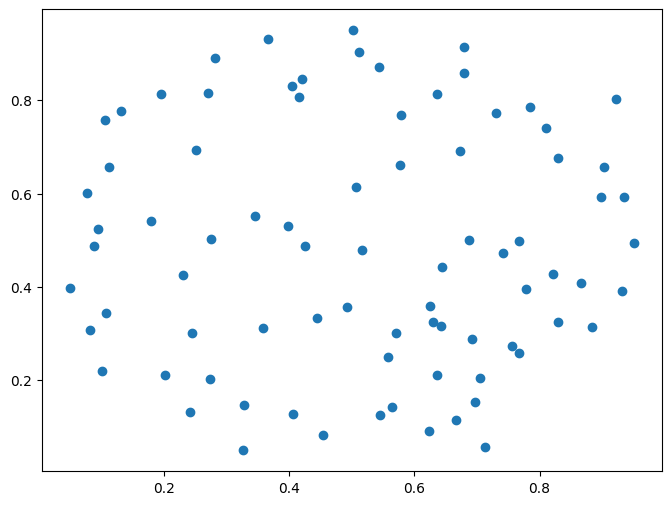

In [121]:
plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1])
plt.show()

# Convert to image

## Find median distance to closest neighbour

We will map this to π/2 so that the cosine will be on its positive side between neighbours.

In [122]:
from scipy.spatial import KDTree

# Build tree
tree = KDTree(coords)

# Query k=2 (first neighbor is the point itself)
distances, _ = tree.query(coords, k=2)

# Calculate median of the 2nd column
median_dist = np.median(distances[:, 1])
print(median_dist)

0.05566747812926265


In [123]:
class Alice:
    def __init__(self, coords, median_dist, grid_size=224, cmap_name='turbo'):
        self.median_dist = median_dist
        self.cmap = plt.get_cmap(cmap_name)
        
        # Pre-calculate Grid
        grid = np.linspace(0, 1, grid_size)
        xn, yn = np.meshgrid(grid, grid)
        
        # Pre-calculate Distances
        dx = xn[None, :, :] - coords[:, 0][:, None, None]
        dy = yn[None, :, :] - coords[:, 1][:, None, None]
        self.dist_matrix = np.sqrt(dx**2 + dy**2)
        
        # Pre-calculate Fade Envelope
        radius = 6 * median_dist
        scaled = np.clip((self.dist_matrix / radius) * np.pi, 0, np.pi)
        envelope = (np.cos(scaled) + 1) / 2
        self.fade_mask = np.cos(self.dist_matrix * (0.5 * np.pi / median_dist)) * envelope

    def to_image(self, row):
        # Weighted sum using pre-calculated fade mask
        intensities = np.sum(self.fade_mask * row.values[:, None, None], axis=0)

        # Normalize
        i_min, i_max = intensities.min(), intensities.max()
        range_val = i_max - i_min
        norm_intensities = (intensities - i_min) / range_val
        
        # Apply Colormap
        result = self.cmap(norm_intensities)[:, :, :3]

        # Soft Black Masking
        zero = -i_min / range_val
        mask = np.clip(np.abs(norm_intensities - zero) / 0.05, 0, 1)
        return result * mask[:, :, None]

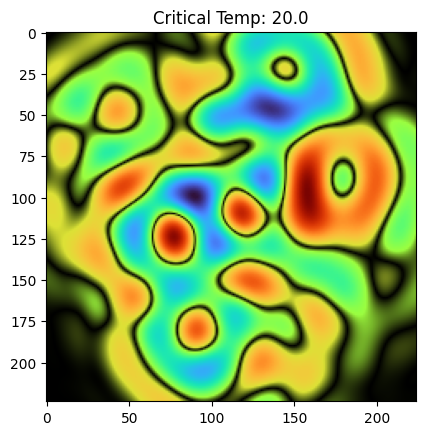

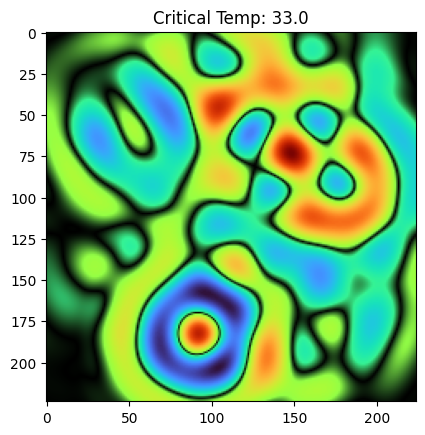

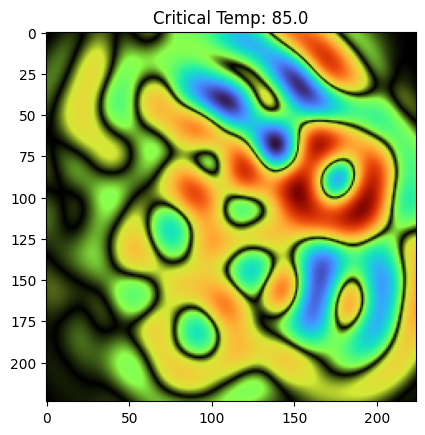

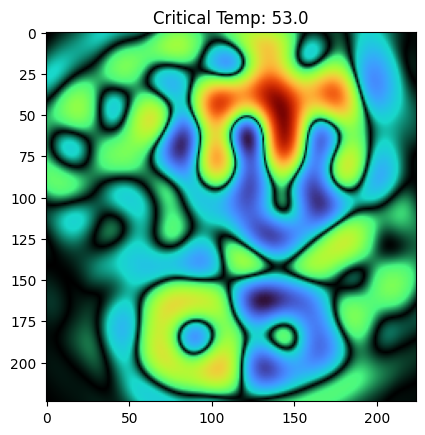

In [124]:
alice = Alice(coords, median_dist)


def showcase(row_num):
    image = alice.to_image(X_train.iloc[row_num])
    
    plt.imshow(image)
    plt.title(f'Critical Temp: {y_train[row_num]}')
    plt.show()

showcase(27)
showcase(7)
showcase(500)
showcase(223)

# Prepare pre-trained CNN

In [125]:
# Use ResNet50 without its classification head. We will replace that with a regression layer.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential([
    base_model,
    layers.GlobalMaxPooling2D(), 
    layers.Dense(256, activation='elu'),
    layers.Dropout(0.2), 
    layers.Dense(1, activation='linear') # Single float output
])

model.compile(
    optimizer='adam', 
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 24,059,393 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Pack CNN inputs

In [126]:
N = len(X_train)
X_images = np.zeros((N, 224, 224, 3), dtype=np.float32)

X_train = X_train.reset_index(drop=True)


for i in range(N):
    X_images[i] = alice.to_image(X_train.iloc[i])
    
    if i % 1000 == 0:
        print(f"Processed {i}/{N} images...")

Processed 0/17010 images...
Processed 1000/17010 images...
Processed 2000/17010 images...
Processed 3000/17010 images...
Processed 4000/17010 images...
Processed 5000/17010 images...
Processed 6000/17010 images...
Processed 7000/17010 images...
Processed 8000/17010 images...
Processed 9000/17010 images...
Processed 10000/17010 images...
Processed 11000/17010 images...
Processed 12000/17010 images...
Processed 13000/17010 images...
Processed 14000/17010 images...
Processed 15000/17010 images...
Processed 16000/17010 images...
Processed 17000/17010 images...


In [127]:
N = len(X_test)
X_test_images = np.zeros((N, 224, 224, 3), dtype=np.float32)

X_test = X_test.reset_index(drop=True)


for i in range(N):
    X_test_images[i] = alice.to_image(X_test.iloc[i])
    
    if i % 1000 == 0:
        print(f"Processed {i}/{N} test images...")

Processed 0/4253 test images...
Processed 1000/4253 test images...
Processed 2000/4253 test images...
Processed 3000/4253 test images...
Processed 4000/4253 test images...


# Train gallery

G:\Programs\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


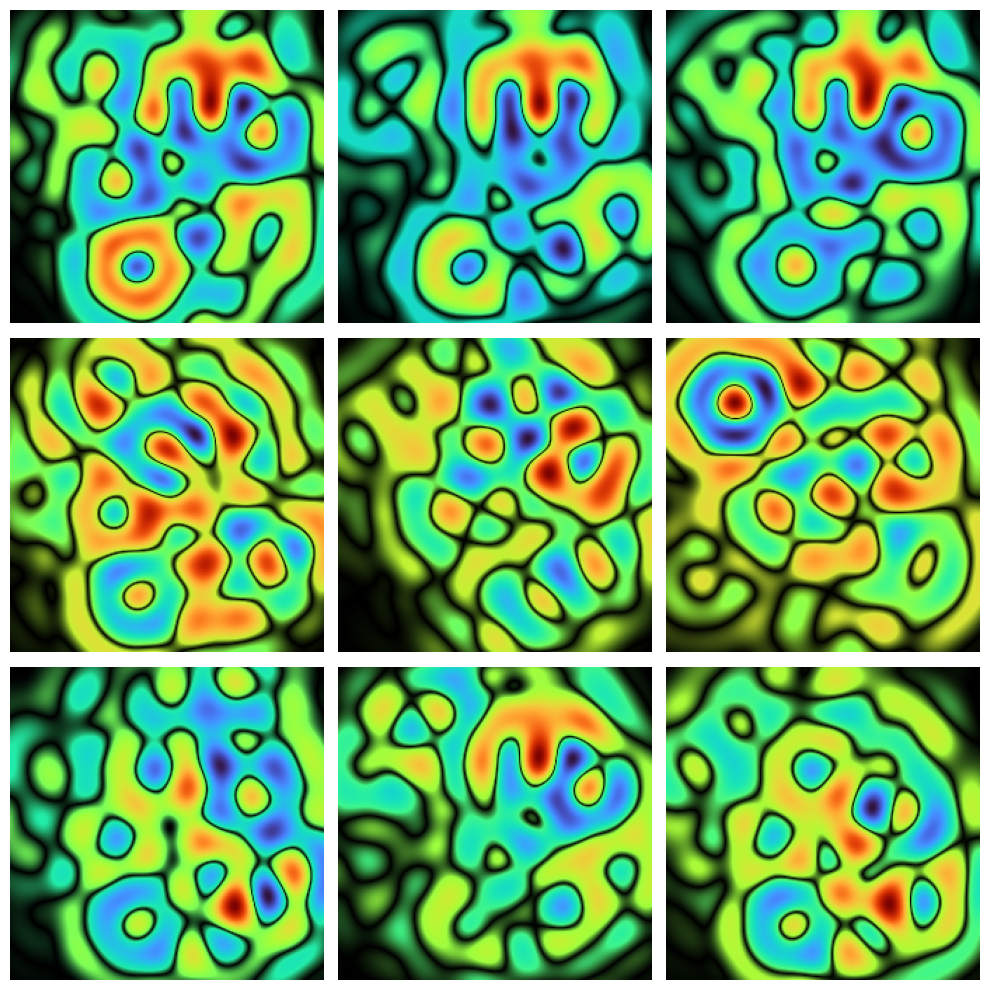

In [128]:

y_train = y_train.reset_index(drop=True)

# 1. Downsample for clustering (4x4)
X_small = np.array([resize(img, (16, 16), anti_aliasing=True) for img in X_images[::17]])
flat_data = X_small.reshape(len(X_small), -1)

# 2. Perform KMeans on tiny data
k = 9
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(flat_data)

# 3. Find closest original images
closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, flat_data)

# 4. Plot 3x3 Gallery (using full-res images)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_images[closest_indices[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Test gallery

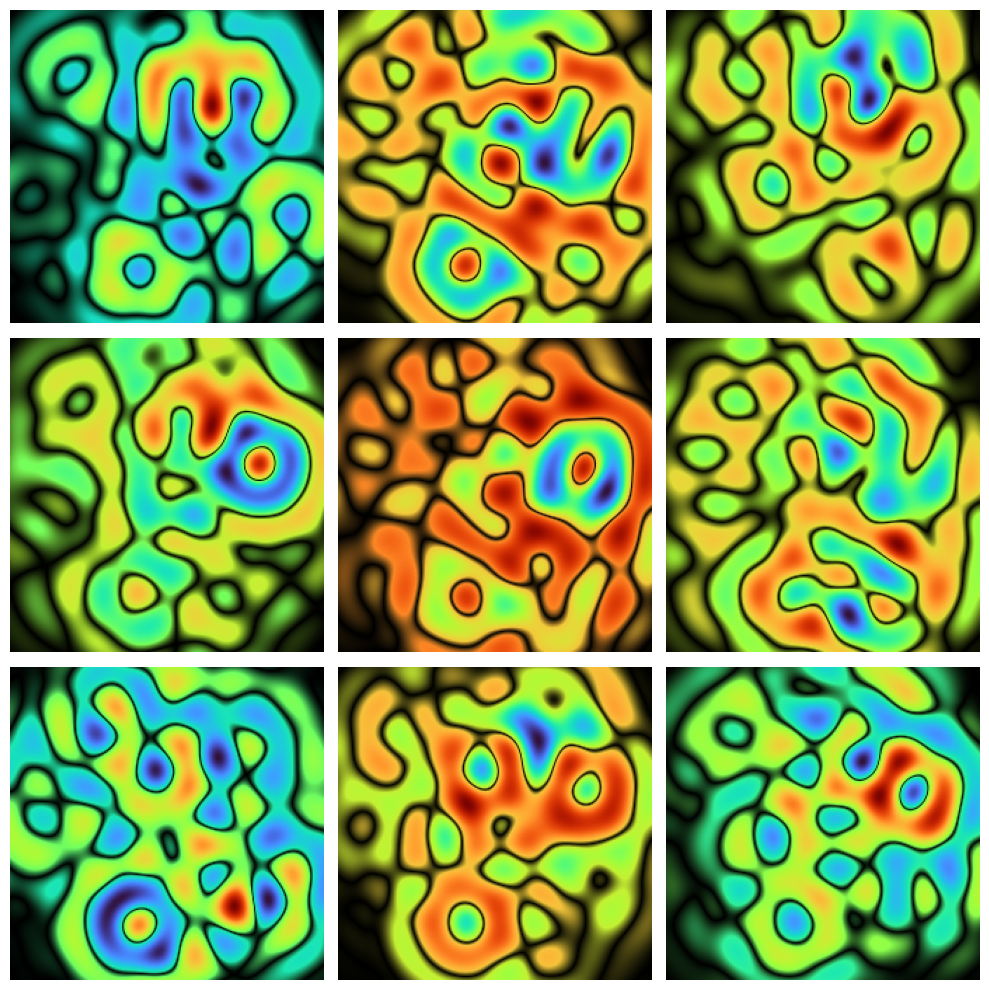

In [129]:
y_test = y_test.reset_index(drop=True)

# 1. Downsample for clustering (4x4)
X_small = np.array([resize(img, (16, 16), anti_aliasing=True) for img in X_test_images[::17]])
flat_data = X_small.reshape(len(X_small), -1)

closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, flat_data)

# 4. Plot 3x3 Gallery (using full-res images)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_images[closest_indices[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Train CNN

In [130]:
history = model.fit(
    X_images,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 1775s 4s/step - loss: 350.0701 - mean_absolute_error: 12.4866 - val_loss: 1689.6522 - val_mean_absolute_error: 28.4343
Epoch 2/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 1690s 4s/step - loss: 221.9428 - mean_absolute_error: 9.9874 - val_loss: 357.0658 - val_mean_absolute_error: 14.0541
Epoch 3/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 1702s 4s/step - loss: 192.3415 - mean_absolute_error: 9.2281 - val_loss: 163.4560 - val_mean_absolute_error: 8.6778
Epoch 4/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 1690s 4s/step - loss: 173.7021 - mean_absolute_error: 8.7767 - val_loss: 165.0752 - val_mean_absolute_error: 8.4324
Epoch 5/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 1728s 4s/step - loss: 157.3730 - mean_absolute_error: 8.4748 - val_loss: 158.3345 - val_mean_absolute_error: 8.6408
Epoch 6/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 1702s 4s/step - loss: 150.2667 - mean_absolute_error: 8.2280 - val_loss: 155.3170 - val_mean_absolute_error: 8.3728
Epoch 7/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 1705s 4s/step - loss

## Fitness curve

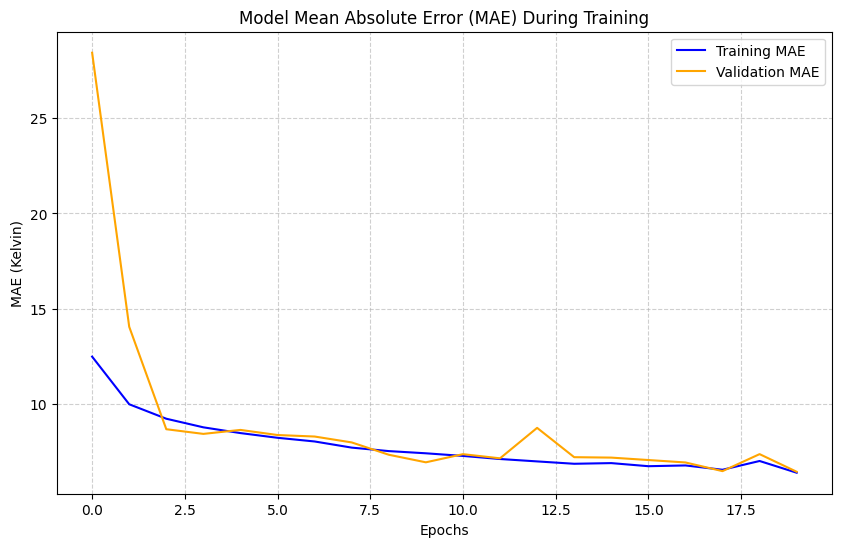

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_absolute_error'], label='Training MAE', color='blue')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='orange')

# Formatting
plt.title('Model Mean Absolute Error (MAE) During Training')
plt.xlabel('Epochs')
plt.ylabel('MAE (Kelvin)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

## Load / save model

In [132]:
#model.save('superconductor_resnet.keras')
model.save('superconductor_resnet_v2.keras')
#model = load_model('superconductor_resnet.keras')

# Test

In [133]:
# Generate predictions
y_pred = model.predict(X_test_images)
y_pred = y_pred.flatten()
y_pred

133/133 ━━━━━━━━━━━━━━━━━━━━ 100s 739ms/step


array([  3.3358834, 118.84442  ,  54.624287 , ...,   1.1137856,
        42.493233 ,  14.535466 ], dtype=float32)

In [134]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE: {mae:.2f} K")
print(f"Test RMSE: {rmse:.2f} K")

Test MAE: 6.68 K
Test RMSE: 10.98 K
